In [1]:
import numpy as np 
import pandas as pd 	
import matplotlib.pyplot as plt 
import math
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from fractions import Fraction
import seaborn as sns

# Naive Bayes - From Scratch

We can expand on the the idea of Bayesean updates with multiple features into a full predictive model. Naive Bayes is one of the most simple predictive algorithms, as it is little more than the Bayes table based updates that we can calculate by hand. 

We'll look at this in a two step process:
<ul>
<li> Create a slightly expanded Bayes table update, that deals with multiple features at once. 
<li> Expand that concpet into a full prediction machine. 
</ul>

The difference between the two is that when creating the model version, we calculate all of the probabilities we might need in advance (the training step), the actual calculation of a prediction is almost the same. 

# 樸素貝葉斯 - 從零開始

我們可以將具有多個特徵的貝葉斯更新的想法擴展到一個完整的預測模型中。 樸素貝葉斯是最簡單的預測算法之一，因為它只不過是我們可以手動計算的基於貝葉斯表的更新。

我們將分兩步來看：
<ul>
<li> 創建一個稍微擴展的貝葉斯表更新，一次處理多個特徵。
<li> 將該概念擴展為完整的預測機器。
</ul>

兩者之間的區別在於，在創建模型版本時，我們預先計算了所有可能需要的概率（訓練步驟），實際計算預測幾乎相同。

#### Udate Function and Load Data

We'll use the weather data from last time, and make predictions both via tables and then a real model. 

In [2]:
def update(table):
    """Compute the posterior probabilities."""
    table['unnorm'] = table['prior'] * table['likelihood']
    prob_data = table['unnorm'].sum()
    table['posterior'] = table['unnorm'] / prob_data
    return prob_data

df = pd.read_table("data/weather.txt")
df.head()

,Outlook,Temp,Humidity,Windy,Play
0,Rainy,Hot,High,f,no
1,Rainy,Hot,High,t,no
2,Overcast,Hot,High,f,yes
3,Sunny,Mild,High,f,yes
4,Sunny,Cool,Normal,f,yes


### Table Bayes Updates

We can do a warm-up to making our model by making an update table simplified version. 

What is the probability of playing when the weather is <b>Sunny, Hot, Normal, False (wind)?</b>

##### Build Table with Outcome Prior Probabilities

### 表貝葉斯更新

我們可以通過製作更新表簡化版本來熱身製作我們的模型。

當天氣為<b>Sunny, Hot, Normal, False (wind)時播放的概率是多少？</b>

##### 用結果先驗概率建表

In [3]:
weather = pd.DataFrame(index=["Play", "Not Play"])
total = len(df)
dfPlay = df[df["Play"] == "yes"]
dfNoPlay = df[df["Play"] == "no"]
pPlay = Fraction(len(df[df["Play"] == "yes"]), total)
weather["prior"] = pPlay, (1 - pPlay)
updates = 1
weather

,prior
Play,9/14
Not Play,5/14


In [4]:
if_playOut = Fraction(len(dfPlay[dfPlay["Outlook"] == "Sunny"]), len(dfPlay))
if_notOut = Fraction(len(dfNoPlay[dfNoPlay["Outlook"] == "Sunny"]), len(dfNoPlay))
weather["likelihood"] = if_playOut, if_notOut
update(weather)
weather

,prior,likelihood,unnorm,posterior
Play,9/14,1/3,3/14,3/5
Not Play,5/14,2/5,1/7,2/5


#### Update Table

We'll tweak the prevous update steps to handle multiple rounds. (This isn't the most efficient way to do this, we're digging through the details here.) We will run the updates just as we did before, the change here is each time I'll rename the old prior and likelihood values, so we keep everything in a larger, growing table, as we go though. 

Because the likelihoods are all going to be multiplied with each other, we'll hold on to all of those values for later. 

<b>Note:</b> The renaming pattern is so we can keep the expected column names and reuse that same update function. 

####更新表

我們將調整先前的更新步驟以處理多輪。 （這不是執行此操作的最有效方法，我們正在此處挖掘詳細信息。）

我們將像以前一樣運行更新，這裡的更改是每次我將重命名舊的先驗值和似然值 ，

因此我們將所有內容保存在一個更大的、不斷增長的表中。

因為可能性都會相互成倍增加，所以我們稍後會保留所有這些值。

<b>注意：</b>重命名模式是為了讓我們可以保留預期的列名並重用相同的更新函數。

In [5]:
weather = weather.rename(columns={"prior": str("prior"+str(updates)), "unnorm": "prior", "likelihood":("likelihood"+str(updates))})
weather = weather.drop(columns={"posterior"})
updates += 1
if_playTemp = Fraction(len(dfPlay[dfPlay["Temp"] == "Hot"]), len(dfPlay))
if_notTemp = Fraction(len(dfNoPlay[dfNoPlay["Temp"] == "Hot"]), len(dfNoPlay))
weather["likelihood"] = if_playTemp, if_notTemp
update(weather)
weather

,prior1,likelihood1,prior,likelihood,unnorm,posterior
Play,9/14,1/3,3/14,2/9,1/21,5/11
Not Play,5/14,2/5,1/7,2/5,2/35,6/11


##### Another Update

Remove the posterior probability, rename the likelihood and prior probability from the last update round. 

In [6]:
weather = weather.rename(columns={"prior": str("prior"+str(updates)), "unnorm": "prior", "likelihood":("likelihood"+str(updates))})
weather = weather.drop(columns={"posterior"})
updates += 1
if_playHum2 = Fraction(len(dfPlay[dfPlay["Humidity"] == "Normal"]) , len(dfPlay))
if_notHum2 = Fraction(len(dfNoPlay[dfNoPlay["Humidity"] == "Normal"]) , len(dfNoPlay))
weather["likelihood"] = if_playHum2, if_notHum2
update(weather)
weather = weather.rename(columns={"prior": str("prior"+str(updates)), "unnorm": "prior", "likelihood":("likelihood"+str(updates))})
weather = weather.drop(columns={"posterior"})
updates += 1
weather

,prior1,likelihood1,prior2,likelihood2,prior3,likelihood3,prior
Play,9/14,1/3,3/14,2/9,1/21,2/3,2/63
Not Play,5/14,2/5,1/7,2/5,2/35,1/5,2/175


#### Last Update Step

After this update I'll keep the posterior probability, since we are done, and I'll drop all the interim prior probabilities since we have no use for them. We will keep the likelihoods, as that set of likelihoods is ultimately all we need to generate predictions. 

Note the final probabilities at the end, either the unnormalized or the posterior probabilities, our categorization prediction will be whichever of those probabilities is larger. Well, if we flash back to the actual Bayes equation:

![Naive Bayes](images/naive_bayes.png "Naive Bayes")

The numerator of that equation is just the prior probability and all of the likelihoods multiplied together, which is the set of values that we have. The denominator of the equation is the same for any outcome, so if we consider it or ignore it doesn't matter - all it does is allow us to normalize the probabilities, which as we can see from the table, we don't need. So... we can make our predictions in general by just calculating all of those likelihoods and the prior probability, multiplying throuhg, and choosing the largest result. 

<b> The Naive Bayes predictive model is just a generalized form of this.</b>

#### 最後更新步驟

在這次更新之後，我將保留後驗概率，因為我們已經完成了，並且我將放棄所有臨時先驗概率，因為我們對它們沒有用。 我們將保留可能性，因為這組可能性最終是我們生成預測所需的全部。

注意最後的最終概率，無論是非歸一化概率還是後驗概率，我們的分類預測將是這些概率中較大的一個。 好吧，如果我們回顧實際的貝葉斯方程：

![樸素貝葉斯](images/naive_bayes.png "樸素貝葉斯")

該等式的分子就是先驗概率和所有可能性相乘，這就是我們擁有的一組值。 等式的分母對於任何結果都是相同的，所以我們考慮或忽略它都沒有關係——它所做的只是允許我們對概率進行歸一化，正如我們從表中看到的那樣，我們不需要 . 所以……我們可以通過計算所有這些可能性和先驗概率、相乘並選擇最大的結果來做出一般性的預測。

<b> 樸素貝葉斯預測模型只是此模型的一般化形式。</b>

In [7]:
if_playWind2 = Fraction(len(dfPlay[dfPlay["Windy"] == "f"]) , len(dfPlay))
if_notWind2 = Fraction(len(dfNoPlay[dfNoPlay["Windy"] == "f"]) , len(dfNoPlay))
weather["likelihood"] = if_playWind2, if_notWind2
update(weather)
weather.drop(columns={"prior2", "prior", "prior3"}, inplace=True)
weather

,prior1,likelihood1,likelihood2,likelihood3,likelihood,unnorm,posterior
Play,9/14,1/3,2/9,2/3,2/3,4/189,125/152
Not Play,5/14,2/5,2/5,1/5,2/5,4/875,27/152


In [8]:
# Self Check
# Play unnormalized probabilities
print(Fraction(9,14)*Fraction(1,3)*Fraction(2,9)*Fraction(2,3)*Fraction(2,3))

4/189


### Results

What we are left with here is a series of likelihoods that each modify our prior probability. If we're keen, we also notice that this series of likelihoods translates directly to the top part of the Bayes equation. The bottom bit is always the same, and we only need that to normalize, so the result of the prediction is whichever unnorm probability is higher. Here 4/189 is more likely than 4/875, so we predict we'll play. 

This is all our classifier needs to do! We just take the prior probabilities and all the likelihoods, multiply them through, and pick the most likely outcome!! This should be pretty easy to put into place:
<ul>
<li> <b>Fitting the Model:</b> The training part of the model can just calculate all of these likelihoods and prior probabilities. Each one was just simple math, so we'll calculate all of them and store them in some kind of list (a dictionary, actually).
    <ul>
    <li> E.g. the likelihood of playing golf if it is sunny can be calculated and saved, same with the prob of not playing if it is windy, etc...
    </ul>
<li> <b>Making Predictions:</b> The predicting part is just looking up the prior and the matching likelihoods from our dictionary of precalculated values, and doing the math. 
</ul>

We are awesome!

＃＃＃ 結果

我們在這裡剩下的是一系列可能性，每個可能性都會修改我們的先驗概率。 

如果我們很敏銳，我們還會注意到這一系列的可能性直接轉化為貝葉斯方程的頂部。 

底部位總是相同的，我們只需要對其進行歸一化，因此預測的結果是哪個非歸一化概率較高。 

這裡 4/189 比 4/875 更有可能，所以我們預測我們會玩。

這就是我們的分類器需要做的所有事情！ 

我們只是採用先驗概率和所有可能性，將它們相乘，然後選擇最有可能的結果！！ 這應該很容易到位：
<ul>
<li> <b>擬合模型：</b>模型的訓練部分可以計算所有這些可能性和先驗概率。 

每一個都只是簡單的數學運算，所以我們將計算所有這些並將它們存儲在某種列表（實際上是字典）中。
     <ul>
     <li> 例如 如果天氣晴朗，可以計算並保存打高爾夫球的可能性，如果有風，則可以計算不打高爾夫球的可能性等......
     </ul>
<li> <b>進行預測：</b> 預測部分只是從我們的預先計算值的字典中查找先驗和匹配可能性，然後進行數學計算。
</ul>

我們很棒！

## Building Naive Bayes

### Parts of the Model

Our predictive model needs to do a few things. The main conceptual difference between this model and doing the Bayes tables is that here we will pre-calculate all of the potential calculations of likelihood that we may need. In the tables, every time we saw a new feature we then calculated its likelihood and updated our probability with it when we did the update to generate the unnormalized and posterior probabilities. Here we will pre-calculate each of those likelihoods ahead of time in the fitting step, so when a prediction needs to be made we can just look up the matching likelihoods and do the multiplication to calculate the answer. Doing it like this means all of the heavy lifting (calculating all of the probabilities) is done while fitting, and creating predictions is fast. 

### Initialization

The initialization step will just setup the pieces that we'll need. Here our initialization declares empty varaibles that will hold everything we calculate and figure out. 

初始化步驟將只設置我們需要的部分。 

在這裡，我們的初始化聲明了空變量，它將保存我們計算和計算出的所有內容。

### Train the Model

The training process is where the model is "built", or where it learns all of the information it needs to be able to make predictions. This is the majority of the work. In short, we need to:
<ul>
<li> <b>Create a list of all the features in our data. </b>
<li> <b>Create a list of all of the likelihood possibilities. </b>
    <ul>
    <li> This is a list of all the potential featureValue_outcome pairs that is possible. 
    <li> The format, with an underscore between the feature and value is arbitrary - we are only creating a replicable item to represent that combination, it could theoretically be anything. 
    </ul>
<li> <b>Calculate the actual likelihood probabilities. </b>
    <ul>
    <li> For each of the possible likelihoods, calculate its actual likelihood value. 
    <li> I.e. what is the actual probability of playing golf given that it is sunny.
    <li> This is the "flipped conditional" part of the Bayes equation. 
    </ul>
<li> <b>Calculate outcome class prior probabilities. </b>
    <ul>
    <li> This is the other part of the numerator in the Bayes equation. 
    </ul>
<li> <b>Calculate the prior probabilities for the features. </b>
    <ul>
    <li> How likely is each potential value for each feature. 
    <li> Used for the bottom of the Bayes equation. 
    </ul>
</ul>

Once done training, no matter what our data actually says, we should have all of the probabilities for it pre-calculated in one of our data structures. 

### Predict

To make a prediction we just need to look up the correct probabilities, and perform the calculation. We can lookup:
<ul><b>
<li> The outcome prior probability. 
<li> Each likelihood. (Flipped conditional)
<li> Each feature prior probability
</b></ul>

$ P(A | B1,B2,B3) = \frac{P(A)*P(B1|A)*P(B2|A)*P(B3|A)}{P(B1)*P(B2)*P(B3)} $

The math to then make a prediction is easy, we can predict the probability for each class by multiplying the outcome prior prob and the likelihoods, then divide by the product of the feature priors to normalize. Highest probability outcome is the prediction. This makes the calculation of the predictions very quick. 

#### Important Bayes Note

One problem that can occur with Bayes is the "zero count" problem, or what if we have a valid value for one of our features that just doesn't occur in our training data. For example, what if there was a day that we were predicting with our weather and golf model where the Humidity was "Dry"? When we attempt to look up the probability of "Humidity = Dry" there won't be anything there and the probability will be 0, since we didn't train for it. Since this will popup on the bottom of the division in the equation, that'll be an issue. This problem is resolved through something called Laplace (or Additive) Smoothing. We won't implement this immediately here (maybe next week? maybe for a fun weekend exercise?) but the idea is relatively simple - when calculating the probability of something, rather than doing the normal calculation of:

$ P(A) = \frac{countA}{totalElements} $

We change that to:

$ P(A) = \frac{countA + alpha}{totalElements + (alpha*numberFeatures)} $

Where alpha is a chosen constant, usually 1. We'll look at how to choose a good alpha when we look at tuning models, the short answer is guess and test. 

This smoothing correction seves to make sure that our model can handle new values without just failing, at the expense of a very minor impact to accuracy on predicted probabilities for things we do know. If a new unseen value comes in, rather than it's probability being 0, which will cause the overall cacluation to fail, its probability will be some small value - almost certainly unlikely to make a tangible difference in our calculations, but enough to keep things rolling. In other words we've sacrificed a tiny bit of accuracy in exchange for much more generalizability. With datasets of a reasonable size, the small additions of the smoothing calculation don't make much of a difference. 

In a perfect world, where we knew every possibility ahead of time and had it embedded in our training data, this smoothing would not be useful and we would not consider it. In reality, Bayes is often used for things like spam detection, where the incoming features are words from the text of an email - in such a case, it is very likely that we will encounter new things when making predictions, so this smoothing is used very frequently when using a Naive Bayes model. 

### Naive Differences

Below we have most of the Naive Bayes algorithm. The "real" ones from sklearn or other packages are basically the same as this - normally just with slightly better error handling, a few more options, and maybe some optimizations for speed - but the idea and execution is almost the same. One change that is actually different in ours is that we are using data in its dataframe format within our algorithm. This is a relatively minor change, and doesn't change any of the concepts behind what we are doing, what it does is make the code a little easier to read and understand as humans, as we can use things like the dataframe's "columns" variable. An implementation using arrays (to work exactly like the sklearn ones) would be almost the same, but places where we refer to columns by names would be replaced by indicies. (In practice, many of the functions can take anything that is "iterable", or can be iterated over one object at a time, like a dataframe, array, or list: https://www.pythonlikeyoumeanit.com/Module2_EssentialsOfPython/Iterables.html)

We can use some print statements to look at exactly what is going on inside our model. This is also a good exercise as if we can't figure something out, printing the current state is the easiest way to diagnose it. 


### Exercise - Complete the Algorithm

There are a few places in the algorithm below where we need to fill in the last little bit. Most of the code is there, but the last couple of calculations are needed. Try to look through the commented code, and figure out what the missing bits should be. Some guidelines:
<ul>
<li> The missing calculations are denoted by ##!!!!!!!!!!!!!!!!!!!!!!!
<li> Each calculation is recognizable from the Bayes calculations that we'd do by hand. 
<li> Try to read and make sense of what is happening, the struggle of trying to read the code and make sense of it is not pure sadism on my part, it is a useful exercise. 
<li> The solution file has answers. 
</ul>

In [9]:
class  NaiveBayes(object):
	def __init__(self):

		"""
			Attributes:
				likelihoods: Likelihood of each feature per class
				class_priors: Prior probabilities of classes 
				pred_priors: Prior probabilities of features 
				features: All features of dataset
			屬性：
				likelihoods: 每個類的每個特徵的可能性
				class_priors: 類的先驗概率
				pred_priors: 特徵的先驗概率
				features: 數據集的所有特徵
		"""
		self.features = list
		self.likelihoods = {} # All of the possible feature-value pairs
		self.class_priors = {} # All class priors
		self.pred_priors = {} # All the predictor priors (for the bottom)

		self.X_train = np.array
		self.y_train = np.array
		self.train_size = int
		self.num_feats = int

	def fit(self, X, y):

		self.features = list(X.columns)
		self.X_train = X
		self.y_train = y
		self.train_size = X.shape[0]
		self.num_feats = X.shape[1]

		# Generate a list of all the possible "likelihoods"
		# Each one is a feature_outcome pair, e.g. from the golf
		# one: Outlook_sunny, Temperature_hot, etc...
		for feature in self.features:
			# Initialize the list of possible values for each feature in the big dictionary of features. 
			self.likelihoods[feature] = {}
			self.pred_priors[feature] = {}

			# Loop through all of the values that this feature can take on, and add that
			# as a possibility to the list of likelihoods for that feature. 
			for feat_val in np.unique(self.X_train[feature]):
				self.pred_priors[feature].update({feat_val: 0})
				#print(feat_val)
				for outcome in np.unique(self.y_train):
					self.likelihoods[feature].update({feat_val+'_'+outcome:0})
					self.class_priors.update({outcome: 0})
					#print('\t'+feat_val+'_'+outcome)
		
		# These functions build the rest of the "learned knowledge" of the model. 
		# Calculate the priors 
		self._calc_class_prior()
		# Calculate the probability of each likelihood
		# We precalculate and save each one so when predictions come
		# we can just look up the probabilities and multiply. 
		self._calc_likelihoods()
		# Generate prior probs for each feature
		self._calc_predictor_prior()

	def _calc_class_prior(self): # calculate yes or no

		""" P(c) - Prior Class Probability """
		print("\nOutcome Priors:")
		# Loop through each outcome
		# Count the occurances to determine prior for the outcome
		for outcome in np.unique(self.y_train):
			outcome_count = sum(self.y_train == outcome)
			self.class_priors[outcome] = outcome_count / self.train_size ##probability
			print(outcome, outcome_count)

	def _calc_likelihoods(self): #Potential how like it is

		""" P(x|c) - Likelihood """
		print("\nLikelihoods:")
		# Loop through each feature
		for feature in self.features:
			print("\tLikelihoods for:", feature)
			# Loop through each outcome of each feature
			for outcome in np.unique(self.y_train):
				outcome_count = sum(self.y_train == outcome)
				# all the likelihood that is possible
				feat_likelihood = self.X_train[feature][self.y_train[self.y_train == outcome].index.values.tolist()].value_counts().to_dict()
				print("\t\tOutcome:", outcome, outcome_count)
				# Loop through each feature value and calculate its probability
				# A.K.A. the probability conditional on the above outcome
				for feat_val, count in feat_likelihood.items():
					self.likelihoods[feature][feat_val + '_' + outcome] = count/outcome_count ##
					print("\t\t\tFeature Value, Count, and Prob:", feat_val, count, count/outcome_count)

	def _calc_predictor_prior(self):

		""" P(x) - Evidence """
		print("\nFeature Priors:")
		# Loop through each feature
		for feature in self.features:
			feat_vals = self.X_train[feature].value_counts().to_dict()
			print("\tFeature:", feature)
			# Loop through each value for the feature, and caclualte proability. 
			# Feature priors, aka the bottom of bayes
			for feat_val, count in feat_vals.items():
				self.pred_priors[feature][feat_val] = count/self.train_size  ## 
				#print(self.pred_priors[feature][feat_val])
				print("\t\tValue, Count, and Prob:", feat_val, count, count/self.train_size)

	def predict(self, X):

		""" Calculates Posterior probability P(c|x) """
		# Make predictions:
		# look up each likelihood, multiply out the likelihood
		# normalize and make a prediction of the highest. 
		results = []
		X = np.array(X)
		print("\nPredictions:")
		# Loop through the things that we are predicting. 
		# Each query is one record from X, our dataset of features. 
		for query in X:
			probs_outcome = {}
			for outcome in np.unique(self.y_train):
				# Get the prior probability of the outcome
				prior = self.class_priors[outcome]
				likelihood = 1
				evidence = 1

				# Loop through each feature, and its value. 
				# get the likelihood for that feature, 
				# update the running probability with that likelihood. 
				for feat, feat_val in zip(self.features, query):
					likelihood *= self.likelihoods[feat][feat_val + '_' + outcome]
					evidence *= self.pred_priors[feat][feat_val]

				# This is the Bayes final calculation
				posterior = (likelihood * prior) / (evidence)  ##
				# store the postirior probability in the array of the results. 
				# each row of data we are predicting gets a prediction, so we end up with a bunch. 
				probs_outcome[outcome] = posterior

			# Translate the posterior probs to a prediction i.e. what is the actual predicted class. 
			# The prediction is whichever outcome is most likely. 
			result = max(probs_outcome, key = lambda x: probs_outcome[x])
			results.append(result)
		# Return an array of all the predictions, just like we are used to getting from any model
		return np.array(results)


In [10]:
def pre_processing(df):

	""" partioning data into features and target """

	X = df.drop([df.columns[-1]], axis = 1)
	y = df[df.columns[-1]]

	return X, y

## Check the Model

Load the data, train the model, check the training accuracy, and run a few tests. 

In [11]:
#Split fearures and target
X,y  = pre_processing(df)

nb_clf = NaiveBayes()
nb_clf.fit(X, y)

print("Train Accuracy: {}".format(accuracy_score(y, nb_clf.predict(X))))

#Query 1:
query = np.array([['Rainy','Mild', 'Normal', 't']])
print("Query 1:- {} ---> {}".format(query, nb_clf.predict(query)))

#Query 2:
query = np.array([['Overcast','Cool', 'Normal', 't']])
print("Query 2:- {} ---> {}".format(query, nb_clf.predict(query)))

#Query 3:
query = np.array([['Sunny','Hot', 'High', 't']])
print("Query 3:- {} ---> {}".format(query, nb_clf.predict(query)))


Outcome Priors:
no 5
yes 9

Likelihoods:
	Likelihoods for: Outlook
		Outcome: no 5
			Feature Value, Count, and Prob: Rainy 3 0.6
			Feature Value, Count, and Prob: Sunny 2 0.4
		Outcome: yes 9
			Feature Value, Count, and Prob: Overcast 4 0.4444444444444444
			Feature Value, Count, and Prob: Sunny 3 0.3333333333333333
			Feature Value, Count, and Prob: Rainy 2 0.2222222222222222
	Likelihoods for: Temp
		Outcome: no 5
			Feature Value, Count, and Prob: Hot 2 0.4
			Feature Value, Count, and Prob: Mild 2 0.4
			Feature Value, Count, and Prob: Cool 1 0.2
		Outcome: yes 9
			Feature Value, Count, and Prob: Mild 4 0.4444444444444444
			Feature Value, Count, and Prob: Cool 3 0.3333333333333333
			Feature Value, Count, and Prob: Hot 2 0.2222222222222222
	Likelihoods for: Humidity
		Outcome: no 5
			Feature Value, Count, and Prob: High 4 0.8
			Feature Value, Count, and Prob: Normal 1 0.2
		Outcome: yes 9
			Feature Value, Count, and Prob: Normal 6 0.6666666666666666
			Feature Value, Count,

### Bayes Notes

We can see here, Bayes works totally differently from a logistic regression, even though it performs the same work. 

There are a few stipulations to using Naive Bayes, and a few varieties made to deal with scenarios that don't meet those stipulations:
<ul>
<li> Naive Bayes only works with categorical features. 
    <ul>
    <li> Other versions of Bayes, such as Gaussian Bayes, allow numerical features to be used. For the Gaussian version, the probabilities are basically changed from the counting we did here, to probability estimates from a normal distribution. 
    </ul>
<li> Normalization isn't relevant to Naive Bayes. 
<li> Encoding categorical varaibles isn't required. 
    <ul>
    <li><b>Note:</b> this is generally true for the algorithm itself, but implementations of NB that you <b><i>might</i></b> use may require numerical inputs. That's a choice whoever made the library made in the design, NB handles categorical strings fine by default. 
    <li> For example, the sklearn implementation requires numerical encoding to work. 
    </ul>
<li> Naive Bayes makes an assumption of independance between each feature, or that one feature's value does not impact another feature. This assumption is often not totally true in the real world (e.g. sunny and hot may tend to come together). The more independent the varaibles are from each other, the more reliable the results will be. 
<li> Naive Bayes can produce multinomial predictions (predicting between more than 2 classes) very easily. Our model above does it by default - each outcome has a probability of occuring, and the most likely one wins. 
    <ul>
    <li> We will look into multiple class predictions more in the ML class, they are not always as simple as they are with Bayes. 
    <li> Each outcome is basically one row of a Bayes table, and we can handle 3+ with no real changes. 
    </ul>
</ul>

### Bayes Uses and Benefits

Bayes models are often used in things like spam detection. Naive Bayes can handle text inputs, and it is very fast to calculate, so that is an ideal scenario for the strength of the algorithm. It is also commonly used in recommendation systems, predicting if someone will like something, as well as sentiment analysis, identifying if text is positive or negative. Some other high points of the Naive Bayes classifier are:
<ul>
<li> The training datatset can be relatively small, so in cases where training data is limited, it may be a strong performer. 
<li> Multiple class predictions can be made with no real adaptations. Other models often require extra work to generate predictions for more than two outcome classes. 
<li> Bayes is also very simple and transparent, we can see exactly how decisions are made by the algorithm. This is also true for the regression algorithms we looked at, but it is not universal. 
</ul>

## Use the Model - Realistic Example

We are predicting the last column, the model. We have multiple classes for our output, and a bunch of categorical inputs. 

#### Data Prep

The data has two things, the make and gear_box, that are categorical values, represented by numbers. We know this is fine, but we do need to check the data type and make sure that this is somehting that python will treat as a categorical value when processed. The most simple way to address that is to just make them strings, which I did below. There's probably several things you could do to these values to make them work, it really doesn't matter much - making it a string will tell python to treat it like other strings, which gets the job done. 

I've also taken a sample, the dataset is large and can take a bit to process. Comment this line out to process it all. 

In [12]:
df2 = pd.read_csv("data/bayes_multi.csv")
df2[["make", "gear_box"]] = df2[["make", "gear_box"]].astype("string")
df2 = df2.sample(10000, random_state=42)
df2.head()

,area_cluster,make,segment,fuel_type,is_esc,is_adjustable_steering,is_tpms,is_parking_sensors,is_parking_camera,rear_brakes_type,...,is_rear_window_defogger,is_brake_assist,is_power_door_locks,is_central_locking,is_power_steering,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert,model
21211,C8,1,B1,CNG,No,No,No,Yes,No,Drum,...,No,No,Yes,Yes,Yes,No,No,Yes,Yes,M8
38111,C12,1,A,CNG,No,No,No,Yes,No,Drum,...,No,No,No,No,Yes,No,No,No,Yes,M1
5549,C5,1,B2,Petrol,No,Yes,No,Yes,No,Drum,...,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,M6
5199,C8,1,B1,CNG,No,No,No,Yes,No,Drum,...,No,No,Yes,Yes,Yes,No,No,Yes,Yes,M8
26260,C15,3,C2,Diesel,Yes,Yes,Yes,Yes,Yes,Disc,...,Yes,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,M4


##### Check the Datatypes

In [13]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 21211 to 19754
Data columns (total 26 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   area_cluster                      10000 non-null  object
 1   make                              10000 non-null  string
 2   segment                           10000 non-null  object
 3   fuel_type                         10000 non-null  object
 4   is_esc                            10000 non-null  object
 5   is_adjustable_steering            10000 non-null  object
 6   is_tpms                           10000 non-null  object
 7   is_parking_sensors                10000 non-null  object
 8   is_parking_camera                 10000 non-null  object
 9   rear_brakes_type                  10000 non-null  object
 10  transmission_type                 10000 non-null  object
 11  gear_box                          10000 non-null  string
 12  steering_type 

##### Check For Nulls

In [14]:
df2.isnull().sum()

area_cluster                        0
make                                0
segment                             0
fuel_type                           0
is_esc                              0
is_adjustable_steering              0
is_tpms                             0
is_parking_sensors                  0
is_parking_camera                   0
rear_brakes_type                    0
transmission_type                   0
gear_box                            0
steering_type                       0
is_front_fog_lights                 0
is_rear_window_wiper                0
is_rear_window_washer               0
is_rear_window_defogger             0
is_brake_assist                     0
is_power_door_locks                 0
is_central_locking                  0
is_power_steering                   0
is_driver_seat_height_adjustable    0
is_day_night_rear_view_mirror       0
is_ecw                              0
is_speed_alert                      0
model                               0
dtype: int64

### Train and Predict

We can use our model almost exactly the same as we use any others. We can mix it in here with the train-test split, and the accuracy score functions from sklearn. The interchangeability that we have with the sklearn stuff carries through most areas, and makes it convinient for us to try new things without needing to learn a lot of specifics about each possible function. 

#### Important Notes for Execution:

For this one we have a few things to watch out for when making predictions. The main thing is that we don't have anything in place to handle the zero probability problem. To avoid this, I tested it and set the random state arguments in the random bits - that should ensure that the randomness is always the same, so if it worked for me once, you should get the same splits. We also have a large dataset and a small test split, so the odds of getting one of those is pretty low. If you dropped the random state argument, it <i><b>could</i></b> happen, and you could get an error. The probability is low and it is random, so the odds are it will still work. At any point in time it might fail though. 

I've also added a stratify argument to the train-test split, that tells it to make sure that each class in y2, the target varible, is represented in each of the training and testing dataset in roughly equal proportions. 

In [15]:
x2, y2 = pre_processing(df2)

columns = df2.columns

X_train, X_test, y_train, y_test = train_test_split(x2, y2, test_size=0.1, stratify=y2, random_state=42)
nb_2 = NaiveBayes()
nb_2.fit(X_train, y_train)

print("Test Accuracy: {}".format(accuracy_score(y_test, nb_2.predict(X_test))))


Outcome Priors:
M1 2282
M10 161
M11 59
M2 159
M3 398
M4 2216
M5 231
M6 2085
M7 412
M8 669
M9 328

Likelihoods:
	Likelihoods for: area_cluster
		Outcome: M1 2282
			Feature Value, Count, and Prob: C3 490 0.2147239263803681
			Feature Value, Count, and Prob: C5 403 0.1765994741454864
			Feature Value, Count, and Prob: C2 265 0.1161262050832603
			Feature Value, Count, and Prob: C10 196 0.08588957055214724
			Feature Value, Count, and Prob: C9 129 0.05652936021034181
			Feature Value, Count, and Prob: C1 123 0.05390008764241893
			Feature Value, Count, and Prob: C7 95 0.04163014899211218
			Feature Value, Count, and Prob: C13 83 0.036371603856266435
			Feature Value, Count, and Prob: C8 79 0.034618755477651184
			Feature Value, Count, and Prob: C4 49 0.02147239263803681
			Feature Value, Count, and Prob: C11 44 0.019281332164767746
			Feature Value, Count, and Prob: C16 44 0.019281332164767746
			Feature Value, Count, and Prob: C14 42 0.018404907975460124
			Feature Value, Count, and Pro

## Exercise

Predict the "outcome" using the Naive Bayes algorithm above. If you're keen, try the sklearn one as well. 

In [16]:
df3 = pd.read_csv("data/turnover.csv",encoding = "ISO-8859-1")
df3["outcome"] = df3["event"].astype("string")
df3.drop(columns={"stag", "extraversion", "independ", "selfcontrol", "anxiety", "novator", "age", "event"}, inplace=True)
df3.head()

,gender,industry,profession,traffic,coach,head_gender,greywage,way,outcome
0,m,Banks,HR,rabrecNErab,no,f,white,bus,1
1,m,Banks,HR,empjs,no,m,white,bus,1
2,f,PowerGeneration,HR,rabrecNErab,no,m,white,bus,1
3,f,PowerGeneration,HR,rabrecNErab,no,m,white,bus,1
4,m,Retail,Commercial,youjs,yes,f,white,bus,1


<AxesSubplot:xlabel='outcome', ylabel='count'>

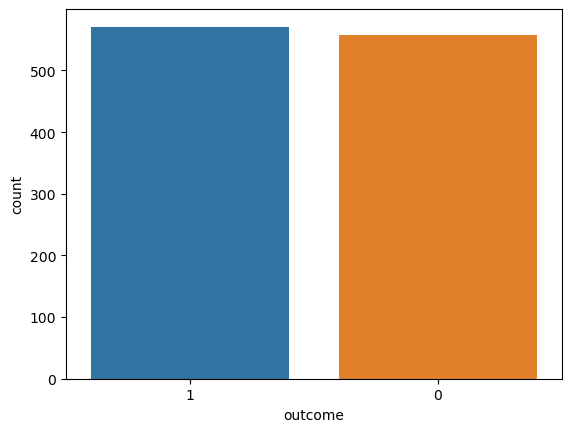

In [17]:
sns.countplot(data=df3, x="outcome")

#### Check Datatypes

In [18]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1129 entries, 0 to 1128
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   gender       1129 non-null   object
 1   industry     1129 non-null   object
 2   profession   1129 non-null   object
 3   traffic      1129 non-null   object
 4   coach        1129 non-null   object
 5   head_gender  1129 non-null   object
 6   greywage     1129 non-null   object
 7   way          1129 non-null   object
 8   outcome      1129 non-null   string
dtypes: object(8), string(1)
memory usage: 79.5+ KB


#### Model

Train model and test accuracy. 

In [19]:
x3, y3 = pre_processing(df3)

columns = df3.columns

X_train3, X_test3, y_train3, y_test3 = train_test_split(x3, y3)
nb_3 = NaiveBayes()
nb_3.fit(X_train3, y_train3)

print("Test Accuracy: {}".format(accuracy_score(y_test3, nb_3.predict(X_test3))))


Outcome Priors:
0 427
1 419

Likelihoods:
	Likelihoods for: gender
		Outcome: 0 427
			Feature Value, Count, and Prob: f 317 0.7423887587822015
			Feature Value, Count, and Prob: m 110 0.2576112412177986
		Outcome: 1 419
			Feature Value, Count, and Prob: f 314 0.7494033412887828
			Feature Value, Count, and Prob: m 105 0.25059665871121717
	Likelihoods for: industry
		Outcome: 0 427
			Feature Value, Count, and Prob: Retail 122 0.2857142857142857
			Feature Value, Count, and Prob: IT 64 0.14988290398126464
			Feature Value, Count, and Prob: manufacture 58 0.1358313817330211
			Feature Value, Count, and Prob: Banks 28 0.06557377049180328
			Feature Value, Count, and Prob: etc 27 0.06323185011709602
			Feature Value, Count, and Prob: PowerGeneration 21 0.04918032786885246
			Feature Value, Count, and Prob: Consult 20 0.0468384074941452
			Feature Value, Count, and Prob: State 19 0.04449648711943794
			Feature Value, Count, and Prob: Telecom 14 0.03278688524590164
			Feature Value, Count

#### Model with SKlearn

Note, you may need to prep the data a bit more. I used the OrdinalEncoder to encode the categorical values. From the sklearn documentation, "It is further assumed that all categories of each feature are represented by the numbers 0, …, n - 1, where n refers to the total number of categories for the given feature. This can, for instance, be achieved with the help of OrdinalEncoder."

In [20]:
from sklearn.naive_bayes import CategoricalNB
from sklearn.preprocessing import OrdinalEncoder

encoder = OrdinalEncoder()
y4 = np.array(df3["outcome"]).reshape(-1,1)
x4 = np.array(df3.drop(columns={"outcome"}))
X_train4, X_test4, y_train4, y_test4 = train_test_split(x4, y4)

model = CategoricalNB().fit(encoder.fit_transform(X_train4), y_train4.ravel())
preds = model.predict(encoder.transform(X_test4))

print("Test Accuracy: {}".format(accuracy_score(y_test4, preds)))

Test Accuracy: 0.5795053003533569
